**Public finance - modelling intensive margin labor supply**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import time
from scipy import linalg
from scipy import optimize
import sympy as sm
import seaborn as sns
from IPython import display

sm.init_printing(use_unicode=True) # for pretty printing

In [86]:
np.seterr(all='print')

{'divide': 'print', 'over': 'print', 'under': 'print', 'invalid': 'print'}

# Describe the model

In this notebook we want to examine the intensive labor supply i.e. hours worked given employment and how the labor supply changes for a given tax change. 

The setup for the model is a follow:
The householdse maxmize utility which is a function of consumption and leisure. The time endowment is normalized to 1, hence leisure can be expressed as $1-h$ where $h$ is the relative time worked. The householde maxmize their utility subjected to the budget constraint. 

\\[ \max u(x,1-h) \text{ s.t. } x=(1-t_{w})wh-t_{0}+a \\]

 - $u(\cdot)$ is the utility funciton
 - $x$ is consumption
 - $1-h$ is leisure
 - $w$ is the wage
 - $t_{w}$ is a tax on labor income
 - $t_{0}$ is lump sum tax
 - $a$ is non-labor income

Is the notebook we will define utility function as a quasi-linear utility function:

\\[ u(x,1-h)=x+\frac{1}{1+\frac{1}{\varepsilon}}(1-h)^{1+\frac{1}{\varepsilon}} \\]

where $\varepsilon$ is the elasticity of substitution

# Define the model in Python

Specify the symbols

In [87]:
x = sm.symbols('x')             # consumption
h = sm.symbols('h')             # working share
epsilon = sm.symbols('epsilon') # elasticity
tw = sm.symbols('t_w')          # tax on labor income
w = sm.symbols('w')             # wage
t0 = sm.symbols('t_0')          # lump sump tax
a = sm.symbols('a')             # non-labor income

Defining the utility function:

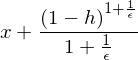

In [88]:
utility=x+(1/(1+1/epsilon))*(1-h)**(1+1/epsilon)
utility

Defining the budget constraint

In [89]:
budget_con = sm.Eq(x,(1-tw)*w*h-t0+a)
budget_con

# Solve the model

**Find optimimum - Algorithm**
1. Insert the budget constraint in the utility function
2. Take the derivative wrt. $h$
3. Solve the first order conditions

**Step 1**

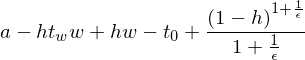

In [90]:
# Find X
x_from_con=sm.solve(budget_con,x)
# Insert the budget constraint in the utility function
utility_sub=utility.subs(x,x_from_con[0])
utility_sub

**Step 2**

In [91]:
#Find first derivative wrt. h
foc=sm.diff(utility_sub,h)
#simplify the expression
foc_sim=sm.simplify(foc)
foc_sim

**Step 3**

In [92]:
#Find the optimal h as a function of the model parameters
sol = sm.solve(foc_sim,h)
sol

# Use solutions

In [93]:
# Turn solution into Python function
_sol_func=sm.lambdify((tw,w,epsilon),sol[0])
def sol_func(tw=0.2,w=10,epsilon=-0.9,a=2,t0=1):
    opt_h=_sol_func(tw,w,epsilon)
    opt_x=(1-tw)*w*opt_h-t0+a
    opt_u=opt_x+1/(1+1/epsilon)*(1-opt_h)**(1+1/epsilon)
    return opt_h, opt_x, opt_u

# find optimum for hours worked, concsumption level and the implied utility
optimal_h,optimal_x,optimal_u=sol_func()

# find optimum for hours worked, consumption level and the implied utility when the tax increases
optimal_h_tax,optimal_x_tax,optimal_u_tax=sol_func(tw=0.5)

sol_func()


In [94]:
#Find optimum for hours worked, consumption level under compensation

# As the utility function is quasi-linear there are no income effect
# This imply that the optimal level hours worked under compensation is 
# the same without compensation
optimal_h_com=optimal_h_tax

#the optimal level of comsumption under compensation can be found as:
optimal_x_com=optimal_u-1/(1+1/(-0.9))*(1-optimal_h_com)**(1+1/(-0.9))


In [95]:
# tax income before tax increase
tax_before=optimal_h*10*0.2

# tax income before tax increase
tax_after=optimal_h_tax*10*0.5

print(tax_before,tax_after)

1.6922138966637712 3.825381056911981


# Plotting results

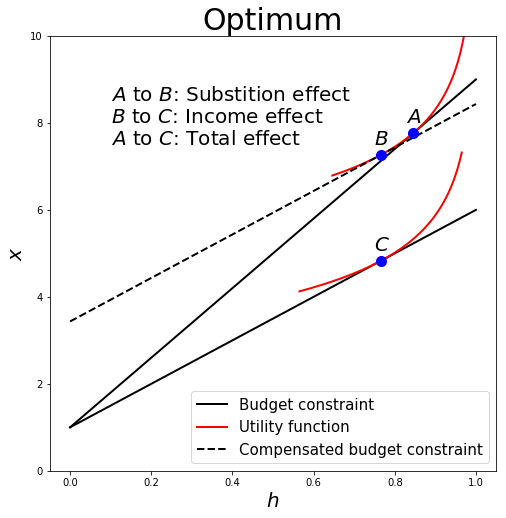

In [99]:
#define function for the budget constraint
def budget_cons(h,tw=0.2,w=10,a=2,t0=1):
    return (1-tw)*w*h-t0+a

#define function for the compensated budget constraint
def budget_cons_comp(h,u_b,u_a,tw=0.5,w=10,a=2,t0=1):
    return (1-tw)*w*h-t0+a+(u_b-u_a)

#define function for the utility function
def utility(h,u,epsilon=-0.9):
    return u-(1/(1+1/epsilon))*(1-h)**(1+1/epsilon)

#make different grids to evaluate the two functions with
grid = np.linspace(0,1,500)
grid_b = np.linspace(optimal_h-0.2,optimal_h+0.2,500)
grid_b_tax = np.linspace(optimal_h_tax-0.2,optimal_h_tax+0.2,500)

#before tax increase
budget_line=budget_cons(grid)
u_func_opt=utility(grid_b,optimal_u)

#after tax increase
budget_line_tax=budget_cons(grid,tw=0.5)
budget_line_tax_com=budget_cons_comp(grid,optimal_u,optimal_u_tax)
u_func_opt_tax=utility(grid_b_tax,optimal_u_tax)

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1)

ax.plot(grid,budget_line,lw=2,linestyle='-',color='black',label='Budget constraint',zorder=-1)
ax.plot(grid_b,u_func_opt,lw=2,linestyle='-',color='red',label='Utility function',zorder=-1)
ax.plot(grid,budget_line_tax,lw=2,linestyle='-',color='black',zorder=-1)
ax.plot(grid,budget_line_tax_com,lw=2,linestyle='--',color='black',label='Compensated budget constraint',zorder=-1)
ax.plot(grid_b_tax,u_func_opt_tax,lw=2,linestyle='-',color='red',zorder=-1)


plt.scatter(optimal_h, optimal_x, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$A$',xy=(optimal_h, optimal_x),xytext=(-7,10),textcoords='offset points',fontsize=20)

plt.scatter(optimal_h_com, optimal_x_com, s=100,zorder=1, marker="o",color='blue')
plt.annotate('$B$',xy=(optimal_h_com, optimal_x_com),xytext=(-7,10),textcoords='offset points',fontsize=20,)

plt.scatter(optimal_h_tax, optimal_x_tax, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$C$',xy=(optimal_h_tax, optimal_x_tax),xytext=(-7,10),textcoords='offset points',fontsize=20,)

plt.text(0.1, 7.5,'$A$ to $B$: Substition effect \n$B$ to $C$: Income effect \n$A$ to $C$: Total effect', fontsize=20)

ax.set_ylim([0,10]);
ax.legend(loc='lower right',fontsize=15)

ax.set_xlabel('$h$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.set_title('Optimum',fontsize=30)
plt.show()

# Optimize the utility numerically

We use the utility-function expressed only as a function $h$

In [100]:
#make the utility function into a python function
def _utility_func(h):
    return (1-0.2)*10*h-1+2+(1/(1+1/(-0.9)))*(1-h)**(1+1/(-0.9))
def utility_func(x):
    #add a -1 to convert the maximization problem into a minimization problem
    return -1*_utility_func(x[0])


Text(0.5, 1.0, 'Optimum')

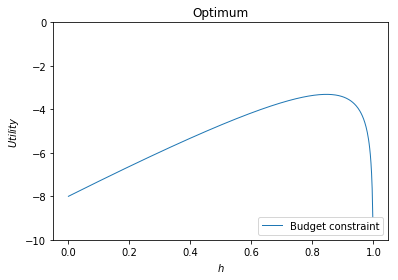

In [101]:
# evaluate the utility function 
u_grid=_utility_func(grid)

#plot the utility function
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(grid,u_grid,lw=1,label='Budget constraint')

ax.set_ylim([-10,0]);
ax.legend(loc='lower right')

ax.set_xlabel('$h$')
ax.set_ylabel('$Utility$')
ax.set_title('Optimum')

In [102]:
x0 = [0.2]
result = optimize.minimize(utility_func,x0,
                           method='BFGS',
                           options={'disp':True}) # display the results

optimal_h_num=result.x
optimal_u_num=(-1)*result.fun
print(f'Optimmal hours worked: {optimal_h_num[0]}')


         Current function value: nan
         Iterations: 1
         Function evaluations: 336
         Gradient evaluations: 112
Optimmal hours worked: 1034.44


# Introduction of af top tax

In the previous example we asumed a linear tax system which implies that marginal tax rate is the same across income levels. In the following we will see what happens when we introduce a top tax. 

With a top tax the marginal tax rate increases from $t_{1}$ to $t_{2}>t_{1}$ when the income exceed a certain threshold $K$.

The budget constraint with progressives taxes can be written as:

\\[ x=(1-t_{1})\cdot min(wh,K)+(1-t_{2})\cdot max(h\cdot w-K,0)-t_{0}+a \\]

To find the optimal choice of $h$ we can use the solution from the previous model in a three step algorithm.

The algorithm to find the consumpers choice of $h$ is:
1. Calculate the optimal choice of $h$ under $t_{1}$ and check if this is a possible solution, i.e the income must be lower than $K$
2. Calculate the optimal choice of $h$ under $t_{2}$ and check if this is a possible solution, i.e the income must be lower than $K$
3. If neither of the two previous choices of $h$ are possible, the consumer will choose $h=\frac{K}{w}$ 

In [103]:
def sol_func_top_tax(f,ta=0.2,tb=0.5,w=10,epsilon=-0.9,a=2,t0=1,K=5):
    #Tax below
    opt_h_below=f(tw=ta,epsilon=epsilon)
    
     #Tax above
    opt_h_above=f(tw=tb,epsilon=epsilon)
    
    #Tax kink
    opt_h_kink=K/w

    if opt_h_below[0]*w<K:
        opt_h=opt_h_below[0]
       
    elif opt_h_above[0]*w>K:
        opt_h=opt_h_above[0]

    else:
        opt_h=opt_h_kink
    
    opt_x=(1-ta)*min(w*opt_h,K)+(1-tb)*max(w*opt_h-K,0)-t0+a
    opt_u=opt_x+1/(1+1/epsilon)*(1-opt_h)**(1+1/epsilon)
 
    return opt_h, opt_x, opt_u
    
optimal_h_top,optimal_x_top,optimal_u_top=sol_func_top_tax(sol_func)
sol_func_top_tax(sol_func)


In [104]:
def budget_cons_top_tax(h,ta=0.2,tb=0.5,w=10,a=2,t0=1,K=5): 
    return (1-ta)*min(w*h,K)+(1-tb)*max(w*h-K,0)-t0+a

#before tax increase
budget_line_top=[]
for i in grid:
    budget_line_top.append(budget_cons_top_tax(i))
    
grid_b_top = np.linspace(optimal_h_top-0.2,optimal_h_top+0.2,500)
u_func_top=utility(grid_b_top,optimal_u_top,epsilon=-0.9)


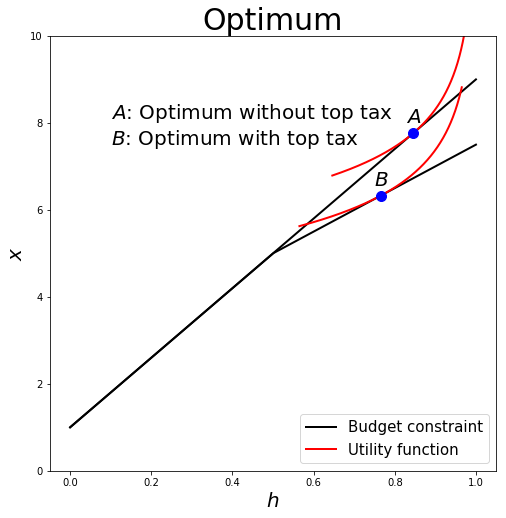

In [105]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1)

ax.plot(grid,budget_line,lw=2,linestyle='-',color='black',label='Budget constraint',zorder=-1)
ax.plot(grid_b,u_func_opt,lw=2,linestyle='-',color='red',label='Utility function',zorder=-1)

ax.plot(grid,budget_line_top,lw=2,linestyle='-',color='black',zorder=-1)
ax.plot(grid_b_top,u_func_top,lw=2,linestyle='-',color='red',zorder=-1)


plt.scatter(optimal_h, optimal_x, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$A$',xy=(optimal_h, optimal_x),xytext=(-7,10),textcoords='offset points',fontsize=20)


plt.scatter(optimal_h_top, optimal_x_top, s=100, zorder=1,marker="o",color='blue')
plt.annotate('$B$',xy=(optimal_h_top, optimal_x_top),xytext=(-7,10),textcoords='offset points',fontsize=20,)

plt.text(0.1, 7.5,'$A$: Optimum without top tax \n$B$: Optimum with top tax', fontsize=20)

ax.set_ylim([0,10]);
ax.legend(loc='lower right',fontsize=15)

ax.set_xlabel('$h$',fontsize=20)
ax.set_ylabel('$x$',fontsize=20)
ax.set_title('Optimum',fontsize=30)
plt.show()

# What happens when we change different parameters in the model

## The distribution of $h$ over different values of $\epsilon$

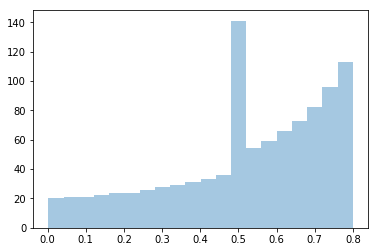

In [106]:
#Make a list over different values of epsilon
epsilon_array = np.arange(-1,0,0.001)
epsilon_list = [round(epsilon,3) for epsilon in epsilon_array]
#remove -1 from the list as it is not a posssile value
epsilon_list.remove(-1)
#Create empty list
hours=[]
cons=[]
utility=[]
#Loop through the list and calculate h for each value of epsilon
for i in epsilon_list:
    _hours,_cons,_utility=sol_func_top_tax(sol_func,epsilon=i)
    hours.append(_hours)
hours
#plot the distribution over h
sns.distplot(hours, bins=20,kde=False);

From the distribution above we can see that people bunch around the threshold for the top tax

## Plot labor supply curve for different values of epsilon 

In [107]:
def fig_func(epsilon):
    fig = plt.figure(figsize=(8,8));
    ax = fig.add_subplot(1,1,1);
    wage_list = list(range(1,50))
    optimal_h_list = []
    optimal_h_list_1 = []
    net_wage = []
    net_wage_1 = []

    for wage in wage_list:
        if round(epsilon,2) == -1:
            continue
        else:
            opt_h, opt_x, opt_u = sol_func(tw=0.2, w=wage, epsilon=round(epsilon,2));
            optimal_h_list.append(opt_h);
            net_wage.append(wage-wage*0.2);
    for wage in wage_list:
        if round(epsilon,2) == -1:
            continue
        else:
            opt_h_1, opt_x_1, opt_u_1 = sol_func(tw=0.5, w=wage, epsilon=round(epsilon,2));
            optimal_h_list_1.append(opt_h_1);
            net_wage_1.append(wage-wage*0.2);
    ax.plot(optimal_h_list_1,net_wage_1,lw=2,linestyle='-',color='blue',label=f'{0.2*100} pct. tax',zorder=-1);
    ax.plot(optimal_h_list,net_wage,lw=2,linestyle='-',color='black',label=f'{0.5*100} pct. tax',zorder=-1);
    ax.set_ylim([0,50]);
    ax.set_xlim([0,1]);
    ax.legend(loc='lower right',fontsize=15);
    ax.set_xlabel('$h$',fontsize=20);
    ax.set_ylabel('Net wage $(w-t \cdot w)$',fontsize=20);
    ax.set_title(f'Labor supply \t $\epsilon$: {round(epsilon, 2)}',fontsize=30);
    return plt.show();

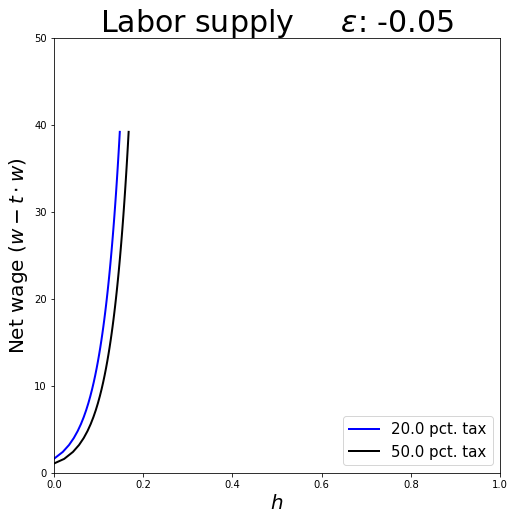

None

In [109]:
#Please run this twice (at least) to get the full experience!
color = ['red', 'black']

epsilon_array = np.arange(-1,0,0.05)
epsilon_list = [round(epsilon,2) for epsilon in epsilon_array]
epsilon_list.remove(-1)
for epsilon in epsilon_list:
    time.sleep(0.3)
    display.display(fig_func(epsilon));
    display.clear_output(wait=True);


# OLD

In [34]:
K = sm.symbols('K') 
ta = sm.symbols('ta') 
tb = sm.symbols('tb') 
                
budget_con = sm.Eq(x,(1-ta)*sm.Min(h,K)+(1-tb)*sm.Max(h-K,0)-t0+a)

x_from_con=sm.solve(budget_con,x)


utility_sub=utility.subs(x,x_from_con[0])

def _utility_func_prog(h):
    return 2-1-0.2*sm.Min(4,h)-0.5*sm.Max(0,-4+h)+sm.Max(0,-4+h)+sm.Min(4,h)+(1/(1+1/(-0.5)))*(1-h)**(1+1/(-0.5))
def utility_func_prog(x):
    #add a -1 to convert the maximization problem into a minimization problem
    return -1*_utility_func_prog(x[0])

AttributeError: 'list' object has no attribute 'subs'

In [101]:
x1 = (0.2)
result = optimize.minimize(utility_func_prog,0.67,
                           method='SLSQP',
                           options={'disp':True}) # display the results

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.011145612951248274
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
